In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import config as fig
import os
import yfinance as yf

In [2]:
def clean_MTL():
    File_path = "../Output/assets/Drop000/"
    Files = os.listdir(File_path)   
    symbol_list = []

    # Initialize an empty DataFrame to store forecasts
    MTL_var = pd.DataFrame(columns=['Date'])
    # Loop through all files

    for file in Files:
        # Skip the ".DS_Store" file
        if file == ".DS_Store":
            continue
        
        path = os.path.join(File_path, file)
        asset_name = file.split('.')[0].split('_')[3]  # Assumes file name is the asset name   
        symbol_list.append(asset_name)
        asset = pd.read_csv(path)
        var_list = asset['Forecast_T_ANN_ARCH']
        MTL_var[asset_name] = var_list
        MTL_var['Date'] = asset['Date_Forecast']
        # Get 'VaR_T_ANN_ARCH' for the given date
            # Get 'VaR_T_ANN_ARCH' for the given date
    
        # Convert the 'date' column to datetime if it's not already
    MTL_var['Date'] = pd.to_datetime(MTL_var['Date'])

    # Set the 'date' column as the index
    MTL_var = MTL_var.set_index('Date')

    # Resample to get the last date of each month
    monthly_MTL_var = MTL_var.resample('M').last()
    
    return monthly_MTL_var

In [3]:
monthly_MTL_var

NameError: name 'monthly_MTL_var' is not defined

In [4]:
def vol_pred(Date,monthly_MTL_var):
    vol_pred = monthly_MTL_var[monthly_MTL_var.index == Date]
    return vol_pred



### Iteration

# 1. Import Data

In [ ]:
symbol_list = ['AAPL', 'MSFT', 'NVDA', 'JNJ', 'NVS','JPM','GS','AMZN','DIS','MCD','NEE','BA','CAT','XOM','CVX','RIO','BHP']
end = dt.datetime.now()
start = end - dt.timedelta(140)
interval = "1wk"

# download data
returns = yf.download(symbol_list, start, end, interval = interval).pct_change()['Adj Close'].dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.12 / 100

In [5]:
def fetch_data_until(end_date):
    symbol_list = fig.indices
    end = end_date
    start = end - dt.timedelta(5)
    interval = "1wk"
    
    # download data
    returns = yf.download(symbol_list, start, end, interval = interval).pct_change()['Adj Close'].dropna()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    risk_free_rate = 0.12 / 100
    
    return returns, mean_returns, cov_matrix, risk_free_rate

    

In [6]:
returns, mean_returns, cov_matrix, risk_free_rate = fetch_data_until(pd.to_datetime('2007-12-21'))

[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [9]:
def predicted_VCV(cov_matrix,month_end):
    adjust_cov_matrix =  cov_matrix.copy()
    monthly_MTL_var = clean_MTL()
    symbol_list = fig.indices
    for symbols in symbol_list:
        adjust_cov_matrix[symbols][symbols] = vol_pred(month_end,monthly_MTL_var)[symbols][0]
        
    return adjust_cov_matrix
    

In [11]:
import scipy.optimize as sco
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    
    # Recall portfolio_annualised_performance(weights, mean_returns, cov_matrix) returns portfolio standard deviation and portfolio return
    p_var = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    p_ret = np.sum(mean_returns*weights)
    return -(p_ret - risk_free_rate/52) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0,0.25)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def MVO_result(df,mean_returns, cov_matrix, risk_free_rate):    

    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    # print ("-"*80)
    # print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    # print (max_sharpe)
    
    weights = max_sharpe['x']
    rp = np.sum(mean_returns*weights)
    sdp = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # print ("-"*80)
    # print ("Weekly Return:", round(rp,5))
    # print ("Weekly Volatility:", round(sdp,5))
    # print ("Max Weekly Sharpe Ratio:", (rp - (risk_free_rate/52))/sdp)
    # print ("\n")
    # print (max_sharpe_allocation)
    return max_sharpe.x

In [ ]:
adjust_cov_matrix = predicted_VCV(cov_matrix,month_end)

In [12]:
import pandas as pd

# # Initialize your data and portfolio
# data = fetch_initial_data()  # Implement this function
# portfolio = initialize_portfolio()  # Implement this function
data = clean_MTL()
weights = []
returns = []
port_returns= []
# Go through each month in your data
for month_end in pd.date_range(start=data.index.min(), end=data.index.max(), freq='M'):
    # Step 2a: Fetch latest data    
    start_month = month_end - pd.Timedelta(weeks=4)
    returns, mean_returns, cov_matrix, risk_free_rate = fetch_data_until(start_month)  # Implement this function
    
    # Monthly Returns
    
    
    # monthly_return = np.sum(mean_returns*weights[])
    # Step 2b: Calculated predicted 1 month rolling volatility into the future

    adjust_cov_matrix = predicted_VCV(cov_matrix,month_end)
 
    allocation_GARCH = MVO_result(returns, mean_returns, adjust_cov_matrix, risk_free_rate)
    weights.append(allocation_GARCH)
    
    # Calculate the portfolio return for this month
    start_price = returns[returns.index ==start_month]
    port_return =  np.dot(start_price, allocation_GARCH) # do i take this weight or the next or previous?)
    port_returns.append(port_return)
    
 
    # portfolio = rebalance_portfolio(portfolio, optimal_weights)  # Implement this function



[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed
[                       0%                       ]

/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[*********************100%***********************]  17 of 17 completed

1 Failed download:
- NEE: No data found for this date range, symbol may be delisted


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[**********************59%***                    ]  10 of 17 completed

KeyboardInterrupt: 

[**********************94%********************   ]  16 of 17 completed

In [177]:
ret_weights = weights.copy()
# Get the start and end dates from weights_df
start_date = ret_weights.index.min().strftime('%Y-%m-%d')
end_date = ret_weights.index.max().strftime('%Y-%m-%d')
tickers = fig.indices
# Download stock price data
data = yf.download(tickers, start=start_date, end=end_date)

# Get the Adjusted Close prices, which accounts for stock splits and dividends
prices = data['Adj Close']

# Reindex the prices DataFrame to match the ret_weights DataFrame
# Forward fill is used to fill the missing values, you can use other methods depending on your use case
prices = prices.reindex(ret_weights.index, method='ffill')


[*********************100%***********************]  17 of 17 completed


In [237]:
returns_df = prices.pct_change()
returns_df

,AAPL,AMZN,BA,BHP,CAT,CVX,DIS,GS,JNJ,JPM,MCD,MSFT,NEE,NVDA,NVS,RIO,XOM
2007-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-31,-0.316640,-0.161269,-0.048937,-0.035265,-0.016126,-0.108004,-0.075589,-0.070443,-0.053373,0.095447,-0.090477,-0.084269,-0.050605,-0.277190,-0.064813,-0.030841,-0.085281
2008-02-29,-0.076389,-0.170270,0.000209,0.091603,0.018876,0.048457,0.086126,-0.149938,-0.012180,-0.142405,0.016783,-0.162402,-0.056619,-0.130134,-0.003165,0.124989,0.019668
2008-03-31,0.147817,0.105941,-0.101703,-0.100164,0.082400,-0.015001,-0.031780,-0.024996,0.046966,0.056581,0.030678,0.043382,0.040637,-0.074802,0.042319,-0.093762,-0.027928
2008-04-30,0.212195,0.102805,0.141052,0.224905,0.050642,0.126406,0.033461,0.159233,0.034222,0.118473,0.068317,0.004933,0.056583,0.038403,-0.017568,0.141220,0.100378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-31,-0.032927,0.235113,0.039288,-0.057480,-0.064418,-0.082824,0.057455,-0.017817,0.028217,0.017974,0.050384,0.057758,0.073141,-0.007956,0.055013,-0.062849,-0.047957
2015-08-31,-0.066196,-0.043383,-0.087787,-0.040135,-0.027852,-0.073119,-0.151000,-0.077144,-0.054995,-0.064643,-0.040085,-0.061949,-0.057322,0.131558,-0.062940,-0.023136,-0.041232
2015-09-30,-0.021816,-0.001950,0.002066,-0.110038,-0.144951,-0.026052,0.003141,-0.078685,-0.006703,-0.048830,0.036939,0.017003,-0.008739,0.096531,-0.054515,-0.078976,-0.011829
2015-10-31,0.083409,0.222724,0.130737,0.040164,0.129219,0.152130,0.112916,0.079075,0.082271,0.061401,0.139247,0.189335,0.052383,0.150913,-0.016210,0.079539,0.112844


In [247]:
ret_weights.iloc[1,:]

0     2.500000e-01
1     5.063902e-16
2     1.439300e-15
3     1.265834e-16
4     0.000000e+00
5     0.000000e+00
6     3.290835e-16
7     3.816483e-16
8     2.296817e-01
9     8.660196e-17
10    6.147587e-02
11    1.209509e-01
12    7.539875e-17
13    3.387501e-02
14    3.987555e-02
15    1.958976e-01
16    6.824326e-02
Name: 2008-01-31 00:00:00, dtype: float64

In [256]:
port_returns = []
for i in range(len(ret_weights)):
    
    portfolio_return =  np.dot(prices.iloc[i,:] ,ret_weights.iloc[i,:])
    port_returns.append(portfolio_return)

In [261]:
# Calculate monthly portfolio returns
weights = ret_weights.values
returns = prices.values
portfolio_returns = (weights * returns).sum(axis=1)
portfolio_returns

array([ 20.48886616,  27.08951126,  33.36272412,  41.10039365,
        47.9204484 ,  42.53152615,  39.8438851 ,  33.38459496,
        37.78110932,  31.64641511,  33.07604933,  30.74521303,
        37.86346912,  35.20657158,  31.98663655,  14.00163341,
        14.73435709,   8.67365372,  24.72276288,  11.95308297,
        34.85693333,  32.0343308 ,  24.4584173 ,  24.61978264,
        32.9542812 ,  30.82776   ,  35.80300239,  36.06504284,
        40.19523948,  32.754333  ,  22.87635708,  25.04939154,
        28.61409914,  33.29352871,  44.82800197,  54.65619332,
        40.07223312,  36.86134851,  53.31127705,  56.68988396,
        53.69507702,  45.67951271,  47.52639338,  43.11034425,
        35.09708715,  32.7051157 ,  34.07069087,  26.85628819,
        28.92833241,  50.86664685,  43.43257963,  37.44309345,
        33.22250662,  19.14968627,  26.42303458,  32.14115762,
        32.99516545,  36.39527455,  36.21753982,  53.2413707 ,
        53.47672358,  65.20018659,  66.25093571,  66.16

In [277]:


# Assume weights_df is your DataFrame with weights, and returns_df is the DataFrame with returns
# Ensure both are aligned and have same index

# Calculate monthly portfolio returns
weights = ret_weights.values
returns = prices.values
portfolio_returns = (weights * returns).sum(axis=1)
portfolio_returns = portfolio_returns[1:]

# Ensure there are no NaN values in portfolio_returns
assert not np.isnan(portfolio_returns).any()


cumulative_returns = np.cumsum(portfolio_returns)



In [290]:

# Now plot the portfolio value with Plotly
import plotly.graph_objects as go

# Get the dates from the weights_df index, skipping the first date
dates = ret_weights.index[1:]

# Convert cumulative_returns to a pandas Series

cumulative_returns_s = pd.Series(ret_weights, index=dates)

fig = go.Figure(data=go.Scatter(x=cumulative_returns_s.index,
                                y=cumulative_returns_s.values,
                                mode='lines',
                                name='Portfolio Value'))
fig.update_layout(title='Portfolio Value Over Time in Dollar Terms',
                  xaxis_title='Date',
                  yaxis_title='Portfolio Value')
fig.show()


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## 1. Do an equally weighted portfoio but using monthly rebalancing to test. compare to a porfolio without it. 

### Equally weighted 

In [147]:
symbol_list = ['AAPL', 'MSFT', 'NVDA', 'JNJ', 'NVS','JPM','GS','AMZN','DIS','MCD','NEE','BA','CAT','XOM','CVX','RIO','BHP']
end ='2022-01-01'
start = '2016-01-01'
interval = "1wk"

# download data
Close_df = yf.download(symbol_list, start, end, interval = interval).pct_change()['Adj Close'].dropna()
# mean_returns = returns.mean()
# cov_matrix = returns.cov()
# risk_free_rate = 0.12 / 100


[*********************100%***********************]  17 of 17 completed


In [175]:

def get_monthly_returns_df (Close_df, start, end):
    
    returns = Close_df.pct_change()
    returns_monthly = (1+returns).resample('M').agg('prod') - 1
    returns_monthly = returns_monthly.loc[start:end] 
    returns_monthly = returns_monthly.dropna()
    
    return returns_monthly

returns_monthly = get_monthly_returns_df(Close_df, start, end)
# Replace "inf" with NaN
returns_monthly = returns_monthly.replace([np.inf, -np.inf], np.nan)

# Fill NaN with median
returns_monthly = returns_monthly.fillna(returns_monthly.median())


In [176]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [177]:
returns_monthly.index

DatetimeIndex(['2016-01-31', '2016-02-29', '2016-03-31', '2016-05-31',
               '2016-06-30', '2016-07-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30', '2017-06-30', '2017-07-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
      

In [178]:
rebalanced_return_list = []
rebalanced_weight_list = []
rebalanced_index_list = []

for i in range(len(returns_monthly.index) - 24):
    
    index = returns_monthly.index
    returns = returns_monthly[index[i] : index[i+24]]
    
    ann_mean_return = returns.mean() * 252
    cov = returns.cov() 
    
    Ef_Front = EfficientFrontier(ann_mean_return, cov)
    weights = Ef_Front.max_sharpe()
    weights = dict(weights)
    Ef_weights = [weights[k] for k in weights.keys()]
    
    ann_port_return = (returns_monthly.mean() * Ef_weights).sum() * 252
    
    rebalanced_index_list.append(index[i + 24])
    rebalanced_return_list.append(ann_port_return)
    rebalanced_weight_list.append(Ef_weights)


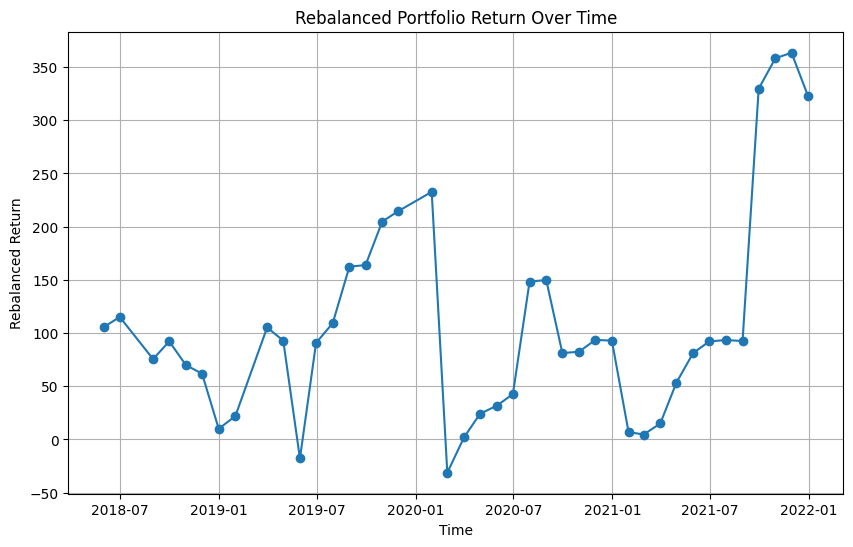

In [179]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rebalanced_index_list, rebalanced_return_list, marker='o', linestyle='-')
plt.title('Rebalanced Portfolio Return Over Time')
plt.xlabel('Time')
plt.ylabel('Rebalanced Return')
plt.grid(True)
plt.show()


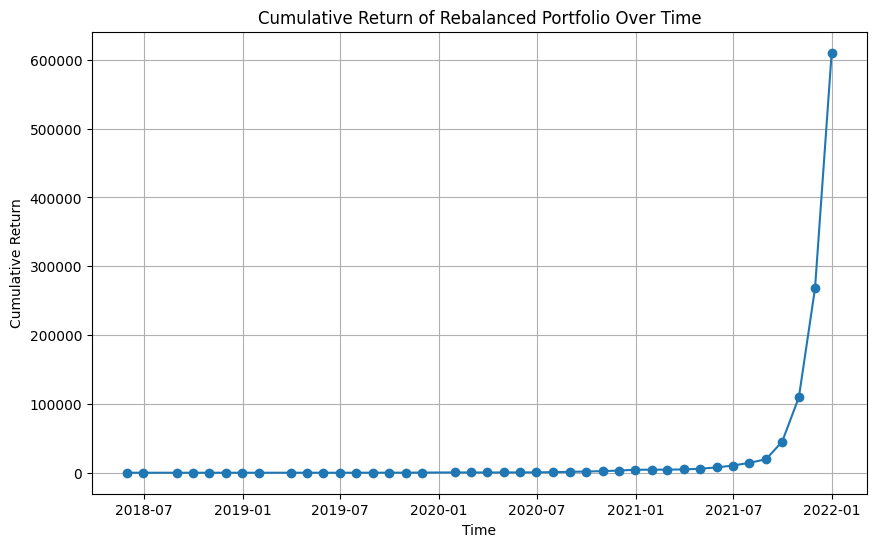

In [180]:
import numpy as np
import matplotlib.pyplot as plt

# Convert annual returns to simple returns
simple_returns = np.array(rebalanced_return_list) / 252

# Calculate cumulative returns
cumulative_returns = np.cumprod(1 + simple_returns) - 1

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(rebalanced_index_list, cumulative_returns, marker='o', linestyle='-')
plt.title('Cumulative Return of Rebalanced Portfolio Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()



In [181]:
df_reb_return = pd.DataFrame(rebalanced_return_list, index=rebalanced_index_list, columns = ['return'])
df_reb_weight = pd.DataFrame(rebalanced_weight_list, index=rebalanced_index_list, columns = returns_monthly.columns)

In [182]:
df_reb_return.cumsum()

,return
2018-05-31,105.555406
2018-06-30,220.639090
2018-08-31,296.192462
2018-09-30,388.365344
2018-10-31,458.217541
2018-11-30,520.035281
2018-12-31,530.014063
2019-01-31,552.051799
2019-03-31,657.291047
2019-04-30,750.151825


## equal weights

In [183]:
rebalanced_return_list = []
rebalanced_weight_list = []
rebalanced_index_list = []

for i in range(len(returns_monthly.index) - 24):
    
    index = returns_monthly.index
    returns = returns_monthly[index[i] : index[i+24]]
    
    Ef_weights = [1/17] * 17
    ann_port_return = (returns.mean() * Ef_weights).sum() * 252
    
    rebalanced_index_list.append(index[i + 24])
    rebalanced_return_list.append(ann_port_return)
    rebalanced_weight_list.append(Ef_weights)


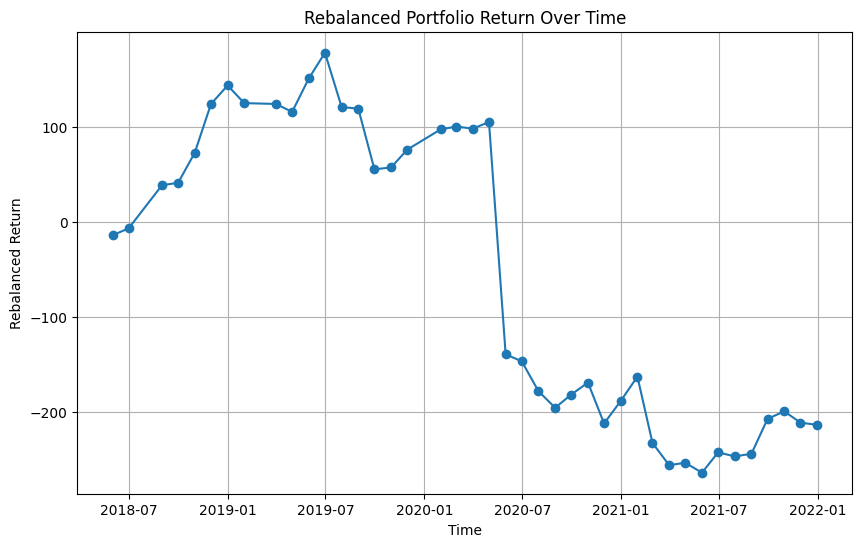

In [184]:
plt.figure(figsize=(10, 6))
plt.plot(rebalanced_index_list, rebalanced_return_list, marker='o', linestyle='-')
plt.title('Rebalanced Portfolio Return Over Time')
plt.xlabel('Time')
plt.ylabel('Rebalanced Return')
plt.grid(True)
plt.show()

In [185]:
df_reb_return = pd.DataFrame(rebalanced_return_list, index=rebalanced_index_list, columns = ['return'])
df_reb_weight = pd.DataFrame(rebalanced_weight_list, index=rebalanced_index_list, columns = returns_monthly.columns)

In [186]:
df_reb_weight

,AAPL,AMZN,BA,BHP,CAT,CVX,DIS,GS,JNJ,JPM,MCD,MSFT,NEE,NVDA,NVS,RIO,XOM
2018-05-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2018-06-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2018-08-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2018-09-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2018-10-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2018-11-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2018-12-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2019-01-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2019-03-31,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
2019-04-30,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824


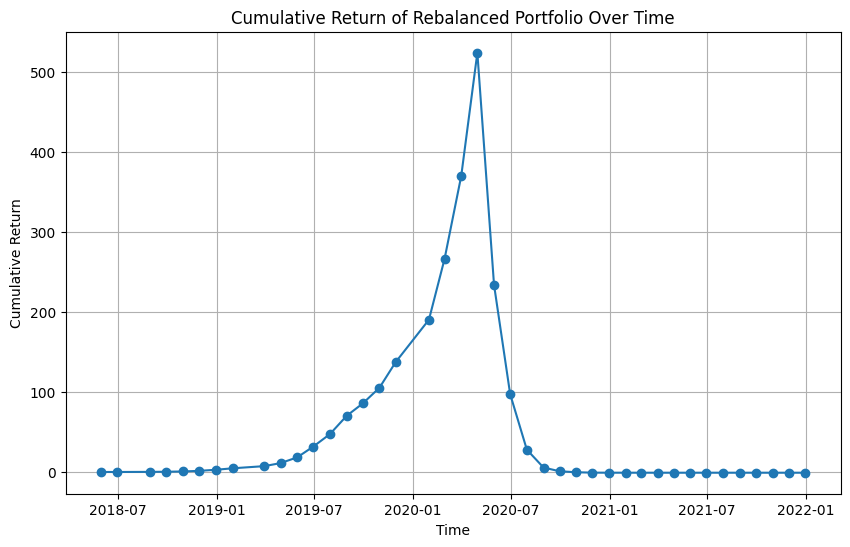

In [187]:

simple_returns = np.array(rebalanced_return_list) / 252

# Calculate cumulative returns
cumulative_returns = np.cumprod(1 + simple_returns) - 1

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(rebalanced_index_list, cumulative_returns, marker='o', linestyle='-')
plt.title('Cumulative Return of Rebalanced Portfolio Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()